<a href="https://colab.research.google.com/github/chandan2294/MNIST_Classification/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Index:**


1. Training a Binary Classifier
2. Performance Measures
  * Measuring Accuracy using Cross-Validation
3. Confusion Matrix
  * Precision and Recall
  * ROC Curve
4. Multiclass Classification
5. Multilabel Classification
6. Multioutput Classification
7. Dummy (i.e., random) Classifier
8. KNN Classifier



In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

We will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Census
Bureau. Each image is labeled with the digit it represents.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset:

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including
the following:
* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per
feature
* A target key containing an array with the labels

In [ ]:
mnist['feature_names']

In [ ]:
mnist['DESCR']

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [ ]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image
is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0
(white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to
do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it
using Matplotlib’s imshow() function:

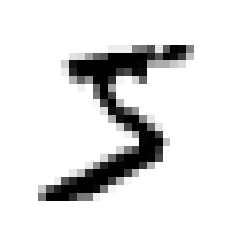

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
some_digit.shape

(784,)

In [ ]:
y[0]

'5'

Note that the label is string. Most ML algorithms expect numbers, so let's cast y to integer:

In [ ]:
y = y.astype(np.uint8)

In [ ]:
def plot_digit(data):
  image = data.reshape(28, 28)
  plt.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
  plt.axis('off')

In [ ]:
#EXTRA
def plot_digits(instances, images_per_row = 10, **options):
  size = 28
  images_per_row = min(len(instances), images_per_row)
  images = [instance.reshape(size, size) for instance in instances]
  n_rows = (len(instances) - 1) // images_per_row + 1
  row_images = []
  n_empty = n_rows * images_per_row - len(instances)
  images.append(np.zeros((size, size * n_empty)))
  for row in range(n_rows):
    rimages = images[row * images_per_row : (row + 1) * images_per_row]
    row_images.append(np.concatenate(rimages, axis = 1))
  image = np.concatenate(row_images, axis = 0)
  plt.imshow(image, cmap = mpl.cm.binary, **options)
  plt.axis('off')

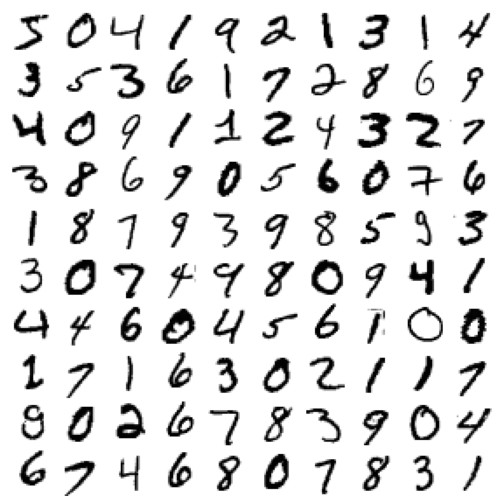

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row = 10)
plt.show()

You should always create a test set and set it aside before inspecting the data
closely. The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
print('Training data: ', X_train.shape)
print('Training label data: ', y_train.shape)
print('Test data: ', X_test.shape)
print('Test label data: ', y_test.shape)

Training data:  (60000, 784)
Training label data:  (60000,)
Test data:  (10000, 784)
Test label data:  (10000,)


The training set is already shuffled for us, which is good because this guarantees that
all cross-validation folds will be similar (you don’t want one fold to be missing some
digits). Moreover, some learning algorithms are sensitive to the order of the training
instances, and they perform poorly if they get many similar instances in a row. Shuffling
the dataset ensures that this won’t happen.

# **Training a Binary Classifier**

Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5. This “5-detector” will be an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.

In [ ]:
y_train_5 = (y_train == 5) #True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient
Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier
has the advantage of being capable of handling very large datasets efficiently. This is
in part because SGD deals with training instances independently, one at a time.

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#Now you can use it to detect images of the number 5:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guesseed right in this case. Now let's evaluate this model's performance.

# **Performance Measures**

**Measuring Accuracy using Cross-Validation**

Occasionally you will need more control over the cross-validation process than what
Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation
yourself. The following code does roughly the same thing as Scikit-Learn’s
cross_val_score() function, and it prints the same result:

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [ ]:
#Out of 60,000, train_index will get 2/3 and test will be 1/3. The folds will keep shifting until the condition is satisfied
print(train_index.shape)
print(test_index.shape)

(40000,)
(20000,)


In [ ]:
X_train_folds.shape

(40000, 784)

In [ ]:
#Let's use the *cross_val_score()* function to evaluate our SGDClassifier model using K fold cv with 3 folds.
#Remember that K-folds cross-validation means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds.

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

It gives above 95% accuracy on all cross-validation folds. 

Now, let's look at a classifier that just classifies  every single image in the 'not-5' class:

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):

  def fit(self, X, y = None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype = bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

# **Confusion Matrix:**

A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the fifth row and third column of the confusion
matrix.
To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets. You could make predictions on the test
set, but let’s keep it untouched for now (remember that you want to use the test set
only at the very end of your project, once you have a classifier that you are ready to
launch). Instead, you can use the cross_val_predict() function:

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions
made on each test fold. This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).
Now you are ready to get the confusion matrix using the confusion_matrix() function.
Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred):

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])


Each row in a confusion matrix represents an actual class, while each column represents
a predicted class. The first row of this matrix considers non-5 images (the negative
class): 53,892 of them were correctly classified as non-5s (they are called true
negatives), while the remaining 687 were wrongly classified as 5s (false positives).
The second row considers the images of 5s (the positive class): 1,891 were wrongly
classified as non-5s (false negatives), while the remaining 3,530 were correctly classified
as 5s (true positives). A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal
(top left to bottom right):


In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_perfect_predictions, y_train_5)

array([[54579,     0],
       [    0,  5421]])

**Precision and Recall**

The accuracy of the positive predictions;
this is called the precision of the classifier

Precision = TP/(TP + FP)

Recall is the ratio of positive instances that are correctly detected by the classifier.

Recall = TP/(TP + FN)

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # 3530/(637 + 3530)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred) # 3530/(3530 + 1891)

0.6511713705958311

Now your 5-detector does not look as shiny as it did when you looked at its accuracy.
When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover,
it only detects 65.11% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1 score is
the harmonic mean of precision and recall.

Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are
high.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall. For example, if you trained a classifier to detect videos
that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier
that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s
video selection). On the other hand, suppose you train a classifier to detect
shoplifters in surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall trade-off.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the previous code returns the same
result as the predict() method (i.e., True). Let’s raise the threshold:

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents
a 5, and the classifier detects it when the threshold is 0, but it misses it when the
threshold is increased to 8,000.


How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions:


In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = 'decision_function')

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

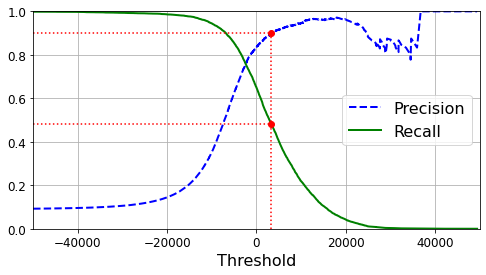

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                             # Not shown
plt.show()

Another way to select a good precision/recall trade-off is to plot precision directly
against recall.

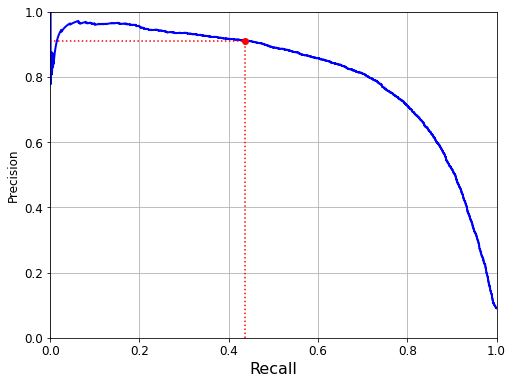

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, 'b-', linewidth = 2)
  plt.xlabel('Recall', fontsize = 16)
  plt.ylabel('Precision', fontsize = 12)
  plt.axis([0,1,0,1])
  plt.grid(True)

plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0, 0.91], "r:")
plt.plot([0.0, 0.4368], [0.91, 0.91], "r:")
plt.plot([0.4368], [0.91], "ro")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall trade-off just before that drop—for example,
at around 60% recall. But of course, the choice depends on your project.

Suppose you decide to aim for 90% precision. You look up the first plot and find that
you need to use a threshold of about 8,000. To be more precise you can search for the
lowest threshold that gives you at least 90% precision (np.argmax() will give you the
first index of the maximum value, which in this case means the first True value):

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
#To make predicitions on the training set
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a
classifier with virtually any precision you want: just set a high enough threshold, and
you’re done. But wait, not so fast. A high-precision classifier is not very useful if its
recall is too low!

# **ROC Curve:**

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus
1 – specificity.


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

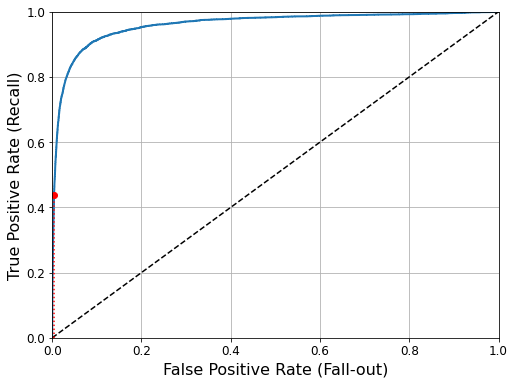

In [ ]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth = 2, label = label)
  plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate (Fall-out)', fontsize = 16)
  plt.ylabel('True Positive Rate (Recall)', fontsize = 16)
  plt.grid(True)

plt.figure(figsize = (8, 6))
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0, 0.4368], "r:")
plt.plot([0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.show()

Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now train a RandomForestClassifier and compare its ROC curve and ROC
AUC score to those of the SGDClassifier. First, you need to get scores for each
instance in the training set. But due to the way it works, the Random
ForestClassifier class does not have a decision_function() method. Instead, it
has a predict_proba() method. Scikit-Learn classifiers generally have one or the
other, or both. 

The predict_proba() method returns an array containing a row per
instance and a column per class, each containing the probability that the given
instance belongs to the given class (e.g., 70% chance that the image represents a 5):

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                    method = 'predict_proba')

In [ ]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
#ROC_Curve expects labels and scores, but instead of scores you can give it class probabilities.

y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

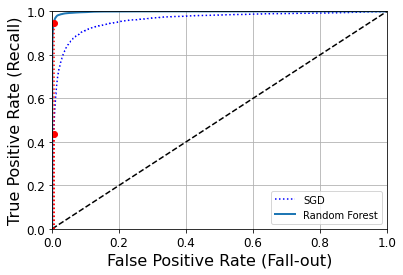

In [ ]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc='lower right')
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

You now know how to train binary classifiers, choose the appropriate metric for your
task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff
that fits your needs, and use ROC curves and ROC AUC scores to compare various
models. Now let’s try to detect more than just the 5s.

# **Multiclass Classification**



In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target
classes from 0 to 9 (y_train), then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels.
If you call the decision_function() method, you will see that it returns 10 scores
per instance (instead of just 1). That’s one score per class:

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In this case, the index of each
class in the classes_ array conveniently matches the class itself.

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you
can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an
instance and pass a classifier to its constructor (it does not even have to be a binary
classifier). For example, this code creates a multiclass classifier using the OvR strategy,
based on an SVC:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
over_clf = OneVsRestClassifier(SVC())
over_clf.fit(X_train, y_train)
over_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(over_clf.estimators_)

10

In [ ]:
#Training an SGDClassifier is just as easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can
directly classify instances into multiple classes. The decision_function() method
now returns one value per class. Let’s look at the score that the SGD classifier assigned
to each class:

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv= 3, scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

**Error Analysis**



In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

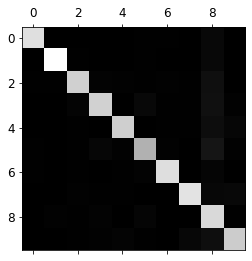

In [ ]:
#It's more convenient to look at an image representation of the confusion matrix
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

This confusion matrix looks pretty good, since most images are on the main diagonal,
which means that they were classified correctly. The 5s look slightly darker than
the other digits, which could mean that there are fewer images of 5s in the dataset or
that the classifier does not perform as well on 5s as on other digits. In fact, you can
verify that both are the case.

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class so that you can compare
error rates instead of absolute numbers of errors (which would make abundant
classes look unfairly bad):

In [ ]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx/row_sums
norm_conf_mx

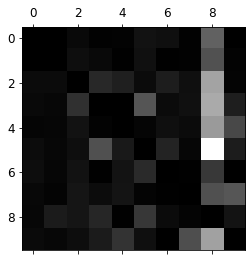

In [ ]:
#Fill the diagonals with zeros to keep only the errors, and plot the result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

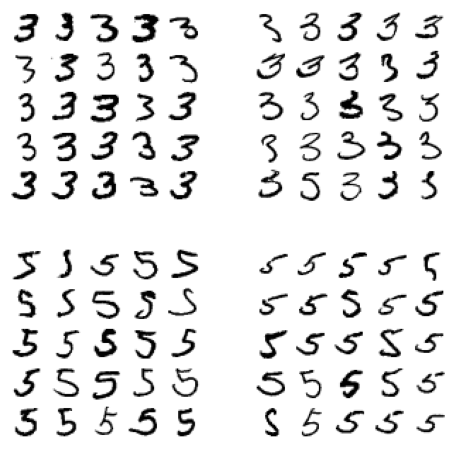

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# **Multilabel Classification**

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. Consider a facerecognition
classifier: what should it do if it recognizes several people in the same
picture? It should attach one tag per person it recognizes. Say the classifier has been
trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is
shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes,
Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is
called a multilabel classification system.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a y_multilabel array containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9), and the second
indicates whether or not it is odd. The next lines create a KNeighborsClassifier
instance (which supports multilabel classification, though not all classifiers do), and
we train it using the multiple targets array. Now you can make a prediction, and
notice that it outputs two labels:

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large (False) and odd (True).

In [ ]:
#To evaluate the model, we measure the F1 score for each individual label
#Then simply compute the average score.

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

This assumes that all labels are equally important, however, which may not be the
case. In particular, if you have many more pictures of Alice than of Bob or Charlie,
you may want to give more weight to the classifier’s score on pictures of Alice. One
simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this, simply set average="weighted" in the
preceding code.

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

0.9778357403921755

# **Multioutput Classification**



In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

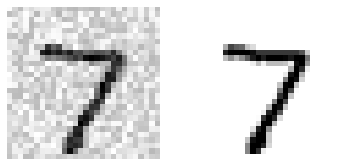

In [ ]:
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()

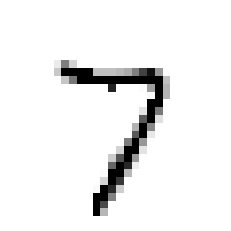

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# **Dummy (i.e. random) classifier**

In [ ]:
from sklearn.dummy import DummyClassifier
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, 
                                 method = "predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


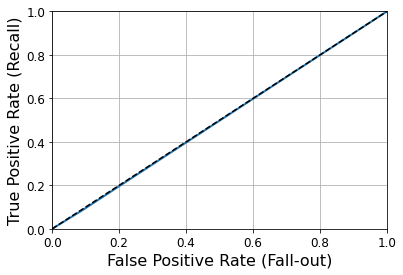

In [ ]:
fprr, tprr, thresholdr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

# **KNN Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights = 'distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

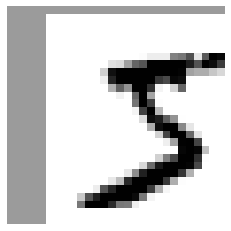

In [ ]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new = 0):
  return shift(digit_array.reshape(28, 28), [dy, dx], cval = new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new = 100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
  shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, 
                                       dx = dx, dy = dy)
  X_train_expanded.append(shifted_images)
  y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [ ]:
ambiguous_digit = X_test[2567]
knn_clf.predict_proba([ambiguous_digit])

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

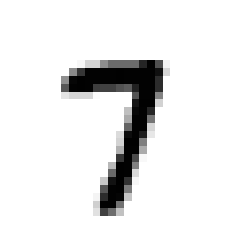

In [ ]:
plot_digit(ambiguous_digit)